<a href="https://colab.research.google.com/github/dlsyscourse/public_notebooks/blob/main/17_generative_adversarial_networks_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 17: Generative adversarial networks implementation

In this lecture, we are going to implement a version of generative adversarial training.



## Prepare the codebase

To get started, please clone a version of needle repo from the github. You should be able to use the need repo after finishng HW2

In [2]:
# Code to set up the assignment
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/
!mkdir -p 10714f22
%cd /content/drive/MyDrive/10714f22
# comment out the following line if you run it for the second time
# as you already have a local copy of code
# !git clone https://github.com/myrepo/needle lecture17
!ln -s /content/drive/MyDrive/10714f22/lecture17 /content/needle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/10714f22
Cloning into 'lecture17'...
remote: Enumerating objects: 917, done.
remote: Counting objects: 100% (184/184), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 917 (delta 104), reused 122 (delta 68), pack-reused 733
Receiving objects: 100% (917/917), 265.21 KiB | 1.99 MiB/s, done.
Resolving deltas: 100% (531/531), done.


In [3]:
!python3 -m pip install pybind11

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.3 MB/s 


We can then run the following command to make the path to the package available in colab's environment as well as the PYTHONPATH.

In [2]:
%set_env PYTHONPATH /content/needle/python:/env/python
import sys
sys.path.append("./python")

env: PYTHONPATH=/content/needle/python:/env/python


## Components of a generative advesarial network

There are two main components in a generative adversarial network
- A generator $G$ that takes a random vector $z$ and maps it to a generated(fake) data $G(z)$.
- A discriminator that attempts to tell the difference between the real dataset and the fake one.



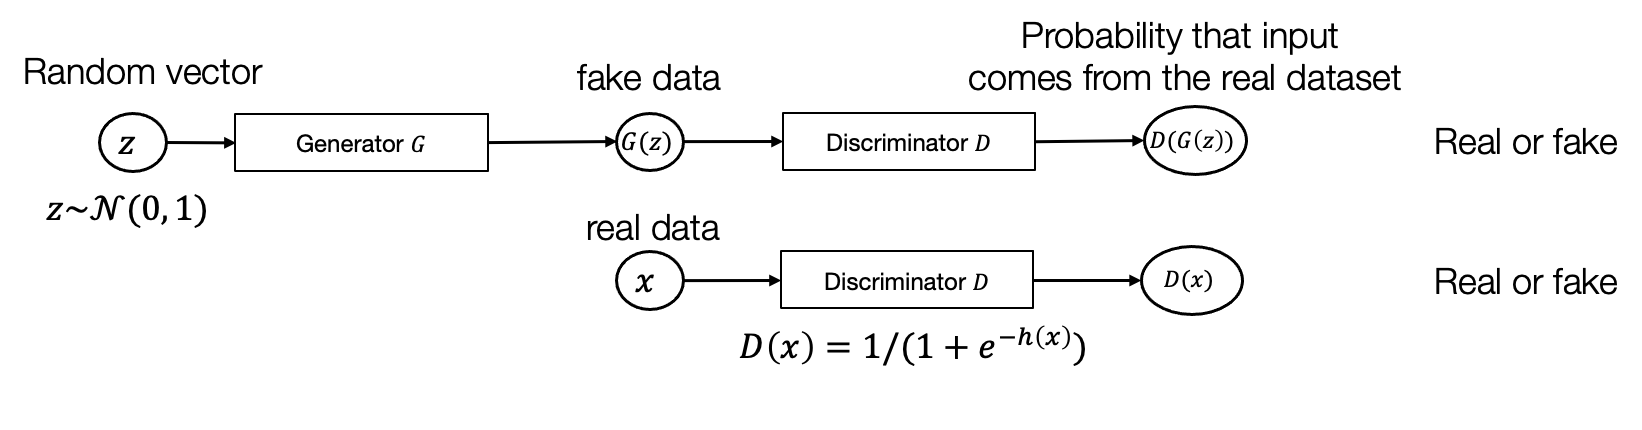

In [3]:
import needle as ndl
import numpy as np
from needle import nn
from matplotlib import pyplot as plt

### Parpare the training dataset

For demonstration purpose, we create our "real" dataset as a two dimensional gaussian distribution. 

\begin{equation} 
X \sim \mathcal{N}(u, \Sigma), \Sigma = A^T A 
\end{equation}

In [4]:
A = np.array([[1, 2], [-0.2, 0.5]])
mu = np.array([2, 1])
# total number of sample data to generated
num_sample = 3200
data = np.random.normal(0, 1, (num_sample, 2)) @ A + mu

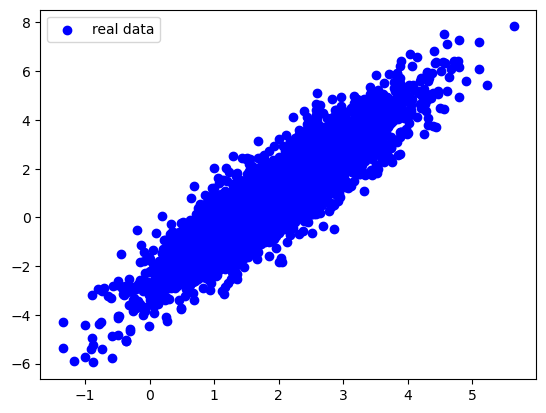

In [6]:
plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.legend()

Our goal is to create a generator that can generate a distribution that matches this distribution.

### Generator network $G$

Now we are ready to build our generator network G, to keep things simple, we make generator an one layer linear neural network.

In [12]:
model_G = nn.Sequential(nn.Linear(2, 2))

In [8]:
def sample_G(model_G, num_samples):
    Z = ndl.Tensor(np.random.normal(0, 1, (num_samples, 2)))
    fake_X = model_G(Z)
    return fake_X.numpy()

In [9]:
fake_data_init = sample_G(model_G, 3200)

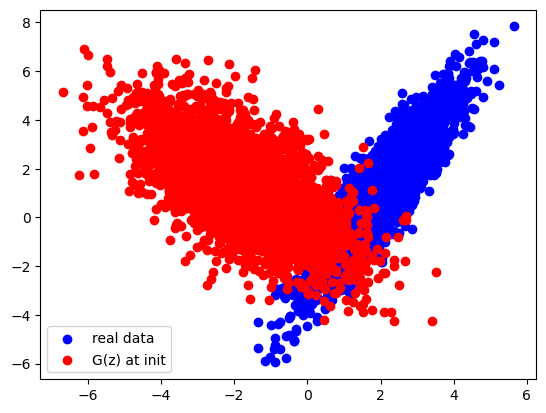

In [14]:
plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.legend()

At the initialization phase, we just randomly initialized the weight of $G$, as a result, it certainly does not match the training data. Our goal is to setup a generative adveserial training to get it to close to the training data.

### Discriminator $D$

Now let us build a discriminator network $D$ that classifies the real data from the fake one. Here we use a three layer neural network. Additionally, we make use of the Softmax loss to measure the classification likelihood. Because we are only classifying two classes. Softmax function becomes the sigmoid function for prediction.

\begin{equation}
    \frac{\exp(x)} {\exp(x) +\exp(y)} =\frac{1}{1 + exp(y-x)} 
\end{equation}

We simply reuse SoftmaxLoss here since this is readily available in our current set of homework iterations. Most implementation will use a binary classification closs instead (BCELoss).

In [15]:
model_D = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
loss_D = nn.SoftmaxLoss()

## Generative advesarial training

A Generative adversarial training process iteratively update the generator $G$ and discriminator $D$ to play a "minimax" game.

\begin{equation}
    \min_D\max_G\{-E_{x\sim Data} \log D(x) - E_{z\sim Noise} \log(1- D(G(z))\}
\end{equation}

Note that however, in practice, the $G$ update step usually use an alternative objective function.

\begin{equation}
    \min_G \{-E_{z\sim{Noise}} \log(D(G(z))\}
\end{equation}


### Generator update

Now we are ready to setup the generator update. In the generator update step, we need to optimize the following goal:

\begin{equation}
    \min_G \{-E_{z\sim{Noise}} \log(D(G(z))\}
\end{equation}

Let us first setup an optimizer for G's parameters.


In [25]:
opt_G = ndl.optim.Adam(model_G.parameters(), lr=0.01)


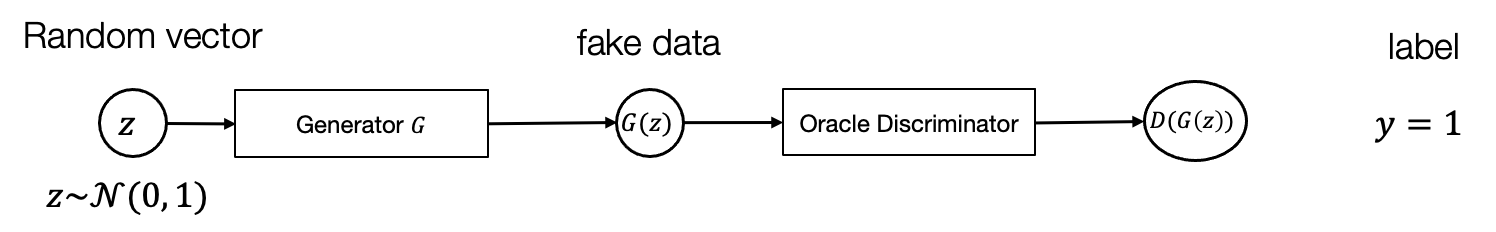

To optimize the above loss function, we just need to generate a fake data $G(z)$, send it through the discriminator $D$ and compute the negative log-likelihood that the fake dataset is categorized as real. In another word, we will feed in $y= 1$ as label here.


In [21]:
def update_G(Z, model_G, model_D, loss_D, opt_G):
    fake_X = model_G(Z)
    fake_Y = model_D(fake_X)
    batch_size = Z.shape[0]
    ones = ndl.ones(batch_size, dtype="float32")  # Because this is fake data, the label should be 1
    loss = loss_D(fake_Y, ones)
    loss.backward() # calculates gradients of parameters
    opt_G.step() # only update parameters of model_G

### Discriminator update

Now, let us also setup the discriminator update step. The discriminator step optimizes the following objective:

\begin{equation}
    \min_D\{-E_{x\sim Data} \log D(x) - E_{z\sim Noise} \log(1- D(G(z))\}
\end{equation}

Let us first setup an optimizer to learn $D$'s parameters.

In [22]:
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)

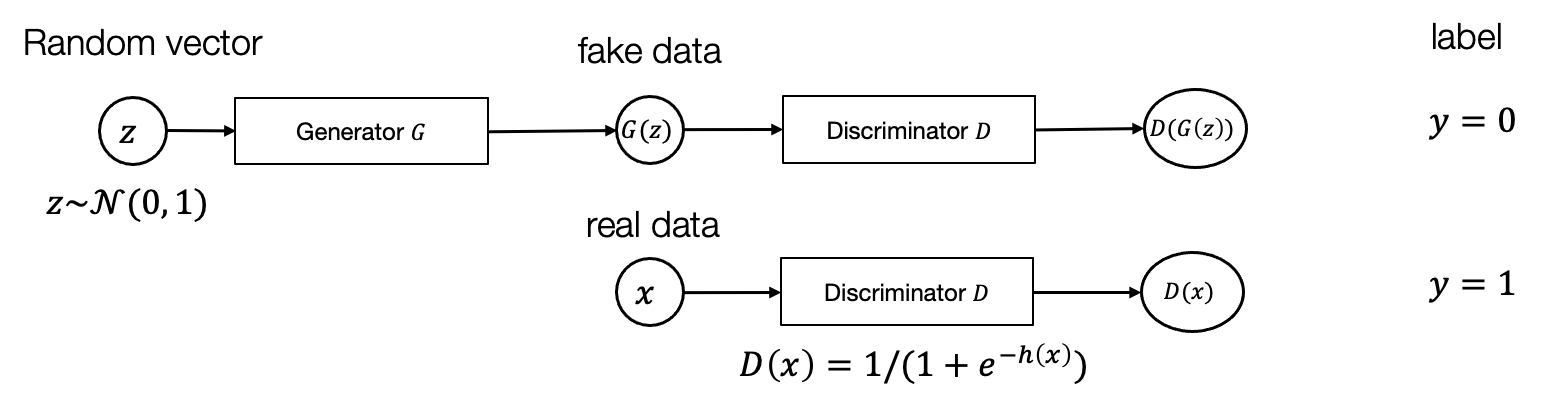

The discriminator loss is also a normal classification loss, by labeling the generated data as $y=0$(fake) and real data as $y=1$(real). Importantly, we also do not need to propagate gradient back to the generator in discriminator update, so we will use the detach function to stop the gradient propagation.


In [23]:
def update_D(X, Z, model_G, model_D, loss_D, opt_D):
    fake_X = model_G(Z).detach()
    fake_Y = model_D(fake_X)
    real_Y = model_D(X)
    assert X.shape[0] == Z.shape[0]
    batch_size = X.shape[0]
    ones = ndl.ones(batch_size, dtype="float32")
    zeros = ndl.zeros(batch_size, dtype="float32")
    loss = loss_D(real_Y, ones) + loss_D(fake_Y, zeros)
    loss.backward()
    opt_D.step()

## Putting it together
Now we can put it together, to summarize, the generative adverserial training cycles through the following steps:
- The discriminator update step
- Generator update step

In [29]:
def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        begin = (batch_size * epoch) % data.shape[0]
        X = data[begin: begin+batch_size, :]
        Z = np.random.normal(0, 1, (batch_size, 2))
        X = ndl.Tensor(X)
        Z = ndl.Tensor(Z)
        update_D(X, Z, model_G, model_D, loss_D, opt_D) 
        update_G(Z, model_G, model_D, loss_D, opt_G)
        if epoch % 100 == 0:
            print("Epoch %d finished" % epoch)

train_gan(data, 32, 2000)

Epoch 0 finished
Epoch 100 finished
Epoch 200 finished
Epoch 300 finished
Epoch 400 finished
Epoch 500 finished
Epoch 600 finished
Epoch 700 finished
Epoch 800 finished
Epoch 900 finished
Epoch 1000 finished
Epoch 1100 finished
Epoch 1200 finished
Epoch 1300 finished
Epoch 1400 finished
Epoch 1500 finished
Epoch 1600 finished
Epoch 1700 finished
Epoch 1800 finished
Epoch 1900 finished


We can plot the generated data of the trained generator after a number of iterations. As we can see, the generated dataset $G(z)$ after get closer to the real data after training.

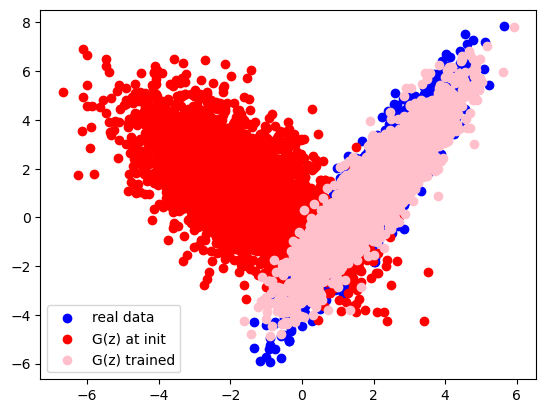

In [30]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.scatter(fake_data_trained[:,0], fake_data_trained[:,1], color="pink", label="G(z) trained")

plt.legend()

### Inspect the trained generator

We can compare the weight/bias of trained generator $G$ to the parameters we use to genrate the dataset. Importantly, we need to compare the covariance $\Sigma= A^T A$ here instead of the transformation matrix.

In [31]:
gA, gmu = model_G.parameters()

In [33]:
A.T @A

array([[1.04, 1.9 ],
       [1.9 , 4.25]])

In [34]:
gA = gA.numpy()
gA.T @ gA

array([[1.1994156, 1.9136152],
       [1.9136152, 3.7763712]], dtype=float32)

In [35]:
A

array([[ 1. ,  2. ],
       [-0.2,  0.5]])

In [36]:
gA

array([[ 0.49314255,  1.54615   ],
       [-0.9778681 , -1.1771965 ]], dtype=float32)

We can also compare the mean

In [37]:
gmu, mu

(needle.Tensor([[2.0142314 1.0214177]]), array([2, 1]))

## Modularizing GAN "Loss"

We can modularize GAN step as in a similar way as loss function. The following codeblock shows one way to do so.

In [40]:
class GANLoss:
    def __init__(self, model_D, opt_D):
        self.model_D = model_D
        self.opt_D = opt_D
        self.loss_D = nn.SoftmaxLoss()

    def _update_D(self, real_X, fake_X):
        real_Y = self.model_D(real_X)
        fake_Y = self.model_D(fake_X.detach())  # Only need the values, not the gradients anymore
        batch_size = real_X.shape[0]
        ones = ndl.ones(batch_size, dtype="float32")
        zeros = ndl.zeros(batch_size, dtype="float32")
        loss = self.loss_D(real_Y, ones) + self.loss_D(fake_Y, zeros)
        loss.backward()
        self.opt_D.step()  # hidden discriminator parameters

    def forward(self, fake_X, real_X):
        self._update_D(real_X, fake_X)
        fake_Y = self.model_D(fake_X)  # NOTE: gradients are needed 
        batch_size = real_X.shape[0]
        ones = ndl.ones(batch_size, dtype="float32")
        loss = self.loss_D(fake_Y, ones)
        return loss


In [41]:
model_G = nn.Sequential(nn.Linear(2, 2))
opt_G = ndl.optim.Adam(model_G.parameters(), lr = 0.01)

model_D = nn.Sequential(
    nn.Linear(2, 20),
    nn.ReLU(),
    nn.Linear(20, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
opt_D = ndl.optim.Adam(model_D.parameters(), lr=0.01)
gan_loss = GANLoss(model_D, opt_D)


def train_gan(data, batch_size, num_epochs):
    assert data.shape[0] % batch_size == 0
    for epoch in range(num_epochs):
        begin = (batch_size * epoch) % data.shape[0]
        X = data[begin: begin+batch_size, :]
        Z = np.random.normal(0, 1, (batch_size, 2))
        X = ndl.Tensor(X)
        Z = ndl.Tensor(Z)
        fake_X = model_G(Z)
        loss = gan_loss.forward(fake_X, X)
        loss.backward()
        opt_G.step()

train_gan(data, 32, 2000)

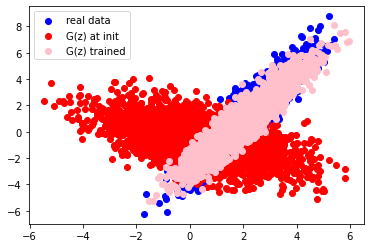

In [33]:
fake_data_trained = sample_G(model_G, 3200)

plt.scatter(data[:,0], data[:,1], color="blue", label="real data")
plt.scatter(fake_data_init[:,0], fake_data_init[:,1], color="red", label="G(z) at init")
plt.scatter(fake_data_trained[:,0], fake_data_trained[:,1], color="pink", label="G(z) trained")

plt.legend()